In [1]:
import os
import pandas as pd
import re
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import BigramCollocationFinder
from nltk import TrigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures
from IPython.display import display
import pymorphy3
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from itertools import combinations
from math import log

Отберем публикации Родного Звука с новыми релизами по шаблону.

In [2]:
posts_rz = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/posts_rz.csv', sep=';')
posts_rz = posts_rz[posts_rz['text'].str.contains(r'\n\b[Оо]т\s?куда\s?:', regex=True, na=False)].copy()
posts_rz = posts_rz[~posts_rz['text'].str.contains(r'\bпо версии (?:наших )?подписчиков\b', regex=True)].copy()
print(posts_rz.shape)
display(posts_rz.head())

(24318, 4)


,id,group_id,date,text
2,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...
4,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...
6,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...
7,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...
8,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...


In [3]:
#Функция для обрезки публикаций: оставим только те абзацы, в которых описывается релиз - остановимся там, где начинается часть поста с фактами о релизе и артисте
def cut(text):
    parts = re.split(r'\n\s?\n', text)
    res = []
    for part in parts:
        if re.search(r'\b[Оо]т\s?куда\s?:', part):
            break
        else:
            res.append(part)
    return '\n\n'.join(res)

In [4]:
posts_rz['cut_text'] = posts_rz['text'].apply(cut)
display(posts_rz.head())

,id,group_id,date,text,cut_text
2,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...,Меланхоличный инди-рок с упором на тексты из М...
4,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...,Андрей Катиков сделал кавер на Братьев Грим.\n...
6,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,Пёрфект ситуэйшн на вечеринке в сингле от [clu...
7,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...,Лиричный эмо-панк из Японии.
8,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл «бессо...


Отсеем те публикации, в которых нет описания релиза, а только информация о нем - здесь после применения функции в обрезанном тексте не останется ничего.

In [5]:
posts_rz = posts_rz[posts_rz['cut_text'] != ''].copy()
print(posts_rz.shape)

(21799, 5)


Создадим и сохраним сэмплы для последующего сравнительного анализа.

In [6]:
#posts_rz_cut1 = posts_rz.sample(n=1100)
#posts_rz_cut2 = posts_rz.sample(n=1100)
#posts_rz_cut3 = posts_rz.sample(n=1100)

In [7]:
#posts_rz_cut1.to_csv('posts_rz_cut1.csv')
#posts_rz_cut2.to_csv('posts_rz_cut2.csv')
#posts_rz_cut3.to_csv('posts_rz_cut3.csv')

Отберем публикации о релизах из двух источников-лейблов - Zion Music и On Лейбл. Здесь для отбора будем с помощью регулярных выражений искать публикации со строками формата "артист - релиз" и отсеем лишнее (продвижение плейлистов, концертов и др.)

In [8]:
posts_zion = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/posts_zion.csv', sep=';')
posts_zion = posts_zion[posts_zion['text'].str.contains(r'\n', na=False)]
posts_zion = posts_zion[posts_zion['text'].str.match(r'^(?=[^—–\n]*\[https://vk\.com[^\]]+\])[^—–\n]+\s+[—–-]\s+[^\[\]]+$', na=False)].copy()
posts_zion = posts_zion[~posts_zion['text'].str.match(r'^(?=[^—–\n]*\[https://vk\.com[^\]]+\])[^—–\n]+[—–-][^\n]+\n\n#[^\s\n]+$')].copy()
posts_zion = posts_zion[~posts_zion['text'].str.match(r'^[^\n]*\b(?:концерт|тур|в гостях|плейлист)\b', na=False)].copy()
print(posts_zion.shape)
display(posts_zion.head())

(570, 4)


,id,group_id,date,text
3,24202,16325867,2026-01-23 04:09:12,[https://vk.com/elvirat_official|Elvira T] – П...
4,24201,16325867,2026-01-23 04:09:01,[https://vk.com/public174256877|Арсен Шахунц] ...
5,24200,16325867,2026-01-23 04:08:51,[https://vk.com/bezobid_music|без обид] – прот...
6,24199,16325867,2026-01-23 04:08:37,[https://vk.com/volodinakristina|моя волна] - ...
9,24173,16325867,2026-01-16 04:03:38,[https://vk.com/officialsvyat|Свят] - Банально...


In [9]:
posts_on = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/posts_on.csv', sep=';')
posts_on = posts_on[posts_on['text'].str.contains(r'(?s)(?=.*[^\n—–]+[—–-]\s*\[https://vk\.com/(?:music|audio)[^\]]+\])', regex=True, na=False)].copy()
pattern = r'(?:обложк(?:ах|и|у)|плейлист(?:а|ы|ах|е)|пресейв нового трека|выкатили итоги)'
posts_on = posts_on[~posts_on['text'].str.contains(pattern, na=False)].copy()
print(posts_on.shape)
display(posts_on.head())

(359, 4)


,id,group_id,date,text
3,2479,222935597,2026-01-24 00:30:36,💿 Релизы недели \n\n[https://vk.com/seemeenoka...
5,2473,222935597,2026-01-16 22:35:24,💿 Релизы недели\n\n[https://vk.com/seemeenokap...
6,2471,222935597,2026-01-16 22:14:47,🎧 Релизы лейбла Zaelo\n\n[https://vk.com/club4...
7,2469,222935597,2026-01-13 21:30:17,Премьера клипа!\n\n[https://vk.com/ayyola.musi...
12,2460,222935597,2025-12-29 18:32:07,🎧 Новое в жанре поп \n\n[https://vk.com/lesha_...


In [10]:
posts_labels = pd.concat([posts_zion, posts_on], ignore_index=True)

In [11]:
def cut2(text):
    parts = re.split(r'\n\s?\n', text)
    res = []
    for part in parts:
        if '#' in part or 'Слушать:' in part:
            continue
        elif re.search(r'(?s)(?=.*[^\n—–]+[—–-]\s*\[https://vk\.com/(?:music|audio)[^\]]+\])', part):
            continue
        elif re.search(r'^(?=[^—–\n]*\[https://vk\.com[^\]]+\])[^—–\n]+[—–-]\s*[^\[\]]+$', part):
            continue
        else:
            res.append(part)
    return '\n\n'.join(res)

In [12]:
posts_labels['cut_text'] = posts_labels['text'].apply(cut2)
display(posts_labels.head())

,id,group_id,date,text,cut_text
0,24202,16325867,2026-01-23 04:09:12,[https://vk.com/elvirat_official|Elvira T] – П...,"Дерзкий поп-трек, в котором женская сила подаё..."
1,24201,16325867,2026-01-23 04:09:01,[https://vk.com/public174256877|Арсен Шахунц] ...,"Лёгкий, тёплый и жизнерадостный трек Арсен Шах..."
2,24200,16325867,2026-01-23 04:08:51,[https://vk.com/bezobid_music|без обид] – прот...,"Это агрессивная альтернатива, смешивающая каче..."
3,24199,16325867,2026-01-23 04:08:37,[https://vk.com/volodinakristina|моя волна] - ...,"Новый трек о чувствах, которые потерпели пораж..."
4,24173,16325867,2026-01-16 04:03:38,[https://vk.com/officialsvyat|Свят] - Банально...,Мечтательный инди-поп с саундтрековым звучанием.


Публикации лейблов сохраним вместе для последующего сравнительного анализа.

In [13]:
#posts_labels.to_csv('posts_labels.csv')

Объединим публикации о новых музыкальных релизах из всех источников, создав общий корпус.

In [14]:
posts_music = pd.concat([posts_rz, posts_labels], ignore_index=True)
print(posts_music.shape)
display(posts_music.head())

(22728, 5)


,id,group_id,date,text,cut_text
0,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...,Меланхоличный инди-рок с упором на тексты из М...
1,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...,Андрей Катиков сделал кавер на Братьев Грим.\n...
2,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,Пёрфект ситуэйшн на вечеринке в сингле от [clu...
3,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...,Лиричный эмо-панк из Японии.
4,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл «бессо...


Проведем предобработку текстов: удалим ссылки, цитирование; исправим отсутствующие пробелы после знаков препинания; удалим дефисы, которые не стоят внутри слов; уберем все символы кроме буквенных, чисел, пробелов и дефисов; избавимся от переносов строк и лишних пробелов.

In [15]:
#Функция для предобработки публикаций
def clean(text):
    text = re.sub(r'(id|club)\d+', '', text) #удаляем внутренние ссылки вк
    text = re.sub(r'https?://\S+|vk\.com/\S+|soundcloud\.com/\S+|vk\.cc/\S+', '', text) #удаляем другие внешние ссылки
    text = re.sub(r'(?<=[,.])(?=\S)', ' ', text)
    text = re.sub(r'(?<!\w)-|-(?!\w)', '', text)
    text = re.sub(r'[^\w\s\d-]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()
    text = text.strip()
    return text

In [16]:
posts_music['clean_text'] = posts_music['cut_text'].apply(clean)
display(posts_music.head())

,id,group_id,date,text,cut_text,clean_text
0,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...,Меланхоличный инди-рок с упором на тексты из М...,меланхоличный инди-рок с упором на тексты из м...
1,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...,Андрей Катиков сделал кавер на Братьев Грим.\n...,андрей катиков сделал кавер на братьев грим ан...
2,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,пёрфект ситуэйшн на вечеринке в сингле от виа ...
3,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...,Лиричный эмо-панк из Японии.,лиричный эмо-панк из японии
4,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл бессон...


Лемматизируем тексты и удалим стоп-слова по расширенному списку, дополненному в ходе работы.

In [17]:
stopwords_ru = stopwords.words('russian') + ['это', 'этот', 'такой', 'который', 'всё', 'ещё', 'the', 'её']

#Функция возвращает сразу три аргумента, которые могут понадобиться дальше - токены, леммы, леммы без стоп-слов
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmas = [[morph.parse(token)[0].normal_form, morph.parse(token)[0].tag.POS] for token in tokens]
    lemmas_no_stop = [lemma for lemma in lemmas if lemma[0] not in stopwords_ru]
    return tokens, lemmas, lemmas_no_stop

In [18]:
posts_music[['tokens', 'lemmas', 'lemmas_no_stop']] = posts_music['clean_text'].apply(lambda x: pd.Series(lemmatize(x)))
display(posts_music.head())

,id,group_id,date,text,cut_text,clean_text,tokens,lemmas,lemmas_no_stop
0,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...,Меланхоличный инди-рок с упором на тексты из М...,меланхоличный инди-рок с упором на тексты из м...,"[меланхоличный, инди-рок, с, упором, на, текст...","[[меланхоличный, ADJF], [инди-рок, NOUN], [с, ...","[[меланхоличный, ADJF], [инди-рок, NOUN], [упо..."
1,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...,Андрей Катиков сделал кавер на Братьев Грим.\n...,андрей катиков сделал кавер на братьев грим ан...,"[андрей, катиков, сделал, кавер, на, братьев, ...","[[андрей, NOUN], [катик, NOUN], [сделать, VERB...","[[андрей, NOUN], [катик, NOUN], [сделать, VERB..."
2,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,пёрфект ситуэйшн на вечеринке в сингле от виа ...,"[пёрфект, ситуэйшн, на, вечеринке, в, сингле, ...","[[пёрфект, NOUN], [ситуэйшн, NOUN], [на, PREP]...","[[пёрфект, NOUN], [ситуэйшн, NOUN], [вечеринка..."
3,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...,Лиричный эмо-панк из Японии.,лиричный эмо-панк из японии,"[лиричный, эмо-панк, из, японии]","[[лиричный, ADJF], [эмо-панк, NOUN], [из, PREP...","[[лиричный, ADJF], [эмо-панк, NOUN], [япония, ..."
4,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл бессон...,"[эфемерная, представляет, свой, новый, сингл, ...","[[эфемерный, ADJF], [представлять, VERB], [сво...","[[эфемерный, ADJF], [представлять, VERB], [сво..."


In [19]:
tokens_music = posts_music['tokens'].explode().dropna().tolist()
print(f'Количество токенов в корпусе: {len(tokens_music)}.')
print(f'Из них уникальных: {len(set(tokens_music))}.')
print()
lemmas_no_stop_music = [lemma[0] for lemma in posts_music['lemmas_no_stop'].explode().dropna().tolist()]
print(f'Количество лемм после удаления стоп-слов: {len(lemmas_no_stop_music)}.')
print(f'Из них уникальных: {len(set(lemmas_no_stop_music))}.')

Количество токенов в корпусе: 517022.
Из них уникальных: 71021.

Количество лемм после удаления стоп-слов: 369759.
Из них уникальных: 36720.


Посмотрим на распределение частей речи в нашем корпусе.

In [20]:
#Функция для вывода датафрема с частеречными тегами и их абсолютной и относительной частотностью
def pos_freq(dataframe):
    pos_list = [lemma[1] for lemma in dataframe['lemmas'].explode().dropna().tolist()]
    freq_pos = Counter(pos_list)
    df = pd.DataFrame(freq_pos.items()).rename(columns={0:'tag', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(pos_list))
    return df

In [76]:
#Функция для вывода столбчатой диаграммы с частеречными тегами и их абсолютной и относительной частотностью
def pos_bars(dataframe):
    dataframe.fillna('NONE', inplace=True)
    dataframe_top = dataframe.dropna().sort_values('rel_freq', ascending=False)
    plt.figure(figsize=(10, 5))
    plt.bar(dataframe_top['tag'][:10], dataframe_top['rel_freq'][:10])
    plt.xlabel('Части речи')
    plt.ylabel('Частотность в корпусе')
    plt.title('Частотность частей речи')
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

In [22]:
pos_freq_music = pos_freq(posts_music)
pos_freq_music.sort_values('rel_freq', ascending=False)
#не имеют частеречного тега числа и слова, написанные латиницей (в основном псевдонимы артистов)

,tag,freq,rel_freq
1,NOUN,189284,0.366104
0,ADJF,98022,0.189590
2,PREP,64226,0.124223
6,CONJ,38849,0.075140
3,VERB,30361,0.058723
5,NaN,24783,0.047934
10,ADVB,18897,0.036550
8,PRCL,13285,0.025695
4,NPRO,12494,0.024165
13,PRTF,8340,0.016131


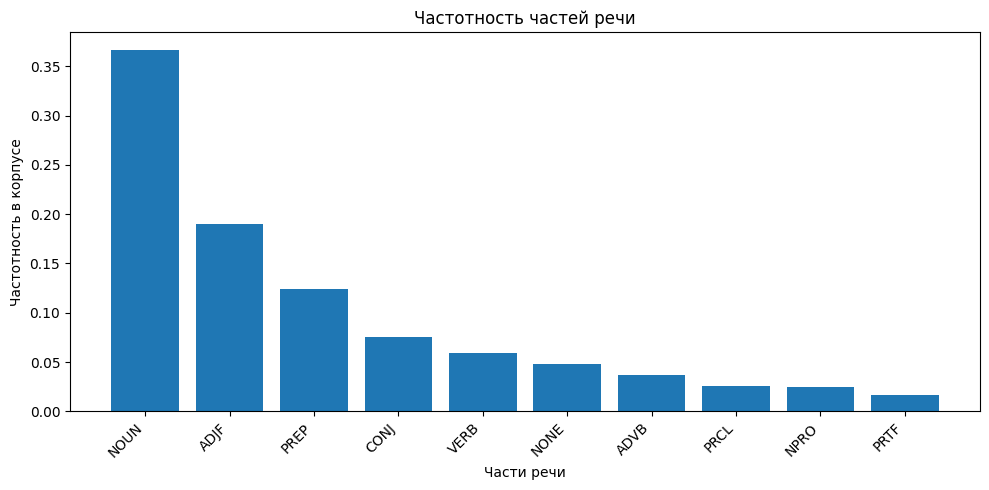

In [77]:
pos_bars(pos_freq_music)

Сравним результаты с референсным корпусом: здесь используется коллекция новостных публикаций Ленты из корпуса "Тайга", отобранная случайным образом, чтобы корпусы были примерно одного размера.

In [ ]:
lenta_texts = []
for txt_file in os.listdir('/Users/sofiacherniakova/Desktop/comp_lingu/project1/texts_lenta'):
    if not txt_file.endswith('.txt'):
        continue 
    with open(f'/Users/sofiacherniakova/Desktop/comp_lingu/project1/texts_lenta/{txt_file}', 'r', encoding='utf-8') as f:
        text = f.read()
        lenta_texts.append(text)
print(f'Всего текстов в корпусе Ленты: {len(lenta_texts)}.')

#lenta = pd.DataFrame(lenta_texts, columns=['text'])
#lenta = lenta.sample(n=2550)
#lenta.to_csv('lenta.csv')

Всего текстов в корпусе Ленты: 36446.


In [25]:
lenta = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/lenta.csv', sep=',')
lenta['clean_text'] = lenta['text'].apply(clean)
lenta[['tokens', 'lemmas', 'lemmas_no_stop']] = lenta['clean_text'].apply(lambda x: pd.Series(lemmatize(x)))
print(lenta.shape)
display(lenta.head())

(2550, 6)


,Unnamed: 0,text,clean_text,tokens,lemmas,lemmas_no_stop
0,21335,\nИранский корабль прошел в опасной близости о...,иранский корабль прошел в опасной близости от ...,"[иранский, корабль, прошел, в, опасной, близос...","[[иранский, ADJF], [корабль, NOUN], [пройти, V...","[[иранский, ADJF], [корабль, NOUN], [пройти, V..."
1,35374,\nБывший тренер пермского «Амкара» Славолюб Му...,бывший тренер пермского амкара славолюб муслин...,"[бывший, тренер, пермского, амкара, славолюб, ...","[[бывший, ADJF], [тренер, NOUN], [пермский, AD...","[[бывший, ADJF], [тренер, NOUN], [пермский, AD..."
2,14723,\nМинтранс предложил регионам отказаться от об...,минтранс предложил регионам отказаться от обяз...,"[минтранс, предложил, регионам, отказаться, от...","[[минтранс, NOUN], [предложить, VERB], [регион...","[[минтранс, NOUN], [предложить, VERB], [регион..."
3,29691,"\nГендиректор издательского дома ""Ньюс Медиа Р...",гендиректор издательского дома ньюс медиа рус ...,"[гендиректор, издательского, дома, ньюс, медиа...","[[гендиректор, NOUN], [издательский, ADJF], [д...","[[гендиректор, NOUN], [издательский, ADJF], [д..."
4,233,\nВ мужской части Открытого чемпионата Франции...,в мужской части открытого чемпионата франции р...,"[в, мужской, части, открытого, чемпионата, фра...","[[в, PREP], [мужской, ADJF], [часть, NOUN], [о...","[[мужской, ADJF], [часть, NOUN], [открытый, AD..."


In [26]:
tokens_lenta = lenta['tokens'].explode().dropna().tolist()
print(f'Количество токенов в корпусе: {len(tokens_lenta)}.')
print(f'Из них уникальных: {len(set(tokens_lenta))}.')
print()
lemmas_no_stop_lenta = [lemma[0] for lemma in lenta['lemmas_no_stop'].explode().dropna().tolist()]
print(f'Количество лемм после удаления стоп-слов: {len(lemmas_no_stop_lenta)}.')
print(f'Из них уникальных: {len(set(lemmas_no_stop_lenta))}.')

Количество токенов в корпусе: 513139.
Из них уникальных: 72100.

Количество лемм после удаления стоп-слов: 382237.
Из них уникальных: 35861.


In [27]:
pos_freq_lenta = pos_freq(lenta)
pos_freq_lenta.sort_values('rel_freq', ascending=False)
#в данном корпусе частеречного тега тоже не имеют числа и слова, написанные латиницей (н-р названия организаций)

,tag,freq,rel_freq
1,NOUN,209349,0.407977
3,PREP,71559,0.139453
0,ADJF,58635,0.114267
2,VERB,47807,0.093166
5,NaN,38568,0.075161
7,CONJ,25014,0.048747
9,ADVB,12221,0.023816
4,NPRO,11671,0.022744
8,INFN,8957,0.017455
10,PRCL,8575,0.016711


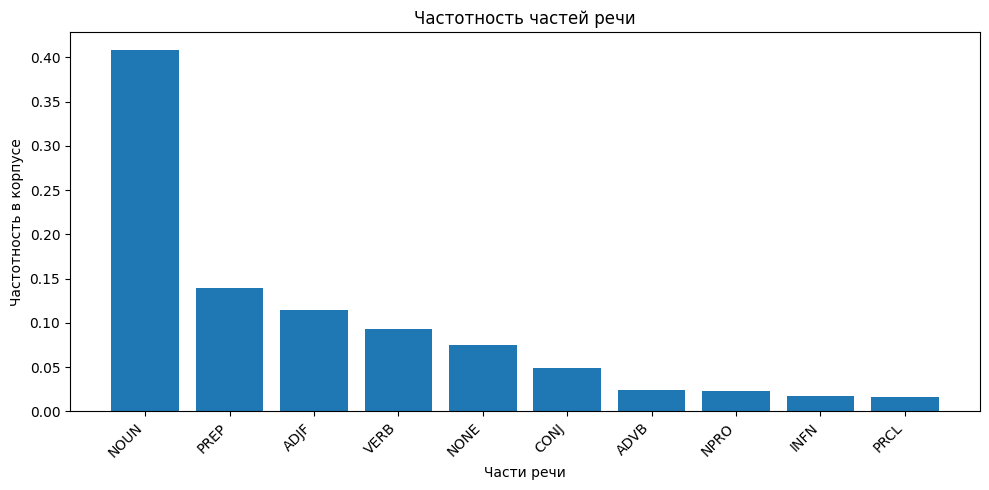

In [78]:
pos_bars(pos_freq_lenta)

Выведем самые частотные леммы по всему корпусу и по наиболее представленным самостоятельным частям речи: существительные, прилагательные, глаголы.

In [29]:
#Функция для вывода датафрейма с леммами после очистки стоп-слов и их абсолютной и относительной частотностью
def lemma_all_freq(dataframe):
    lemmas_list = [lemma[0] for lemma in dataframe['lemmas_no_stop'].explode().dropna().tolist()]
    freq_lemmas = Counter(lemmas_list)
    df = pd.DataFrame(freq_lemmas.items()).rename(columns={0:'lemma', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(lemmas_list))
    return df

In [30]:
#Функция для вывода датафрейма с леммами определенной части речи и их абсолютной и относительной частотностью
def lemma_tag_freq(dataframe, tag):
    lemmas_tag = [lemma[0] for lemma in dataframe['lemmas_no_stop'].explode().dropna().tolist() if lemma[1] == tag]
    freq_lemmas = Counter(lemmas_tag)
    df = pd.DataFrame(freq_lemmas.items()).rename(columns={0:'lemma', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(lemmas_tag))
    return df

In [31]:
#Функция для генерации облака слов из датафрейма с леммами и их частотностью
def wordcloud_from_freq(dataframe):
    freq_dict = dict(zip(dataframe['lemma'], dataframe['freq']))
    wordcloud = WordCloud(max_words=200, background_color='white', colormap = 'inferno_r', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [32]:
lemma_freq_music = lemma_all_freq(posts_music)
lemma_freq_music.sort_values('rel_freq', ascending=False)[:20]

,lemma,freq,rel_freq
35,новый,6758,0.018277
18,альбом,5479,0.014818
12,песня,4467,0.012081
260,группа,4143,0.011205
199,трек,2943,0.007959
26,сингл,2674,0.007232
34,свой,2231,0.006034
20,год,1800,0.004868
143,музыка,1796,0.004857
68,релиз,1532,0.004143


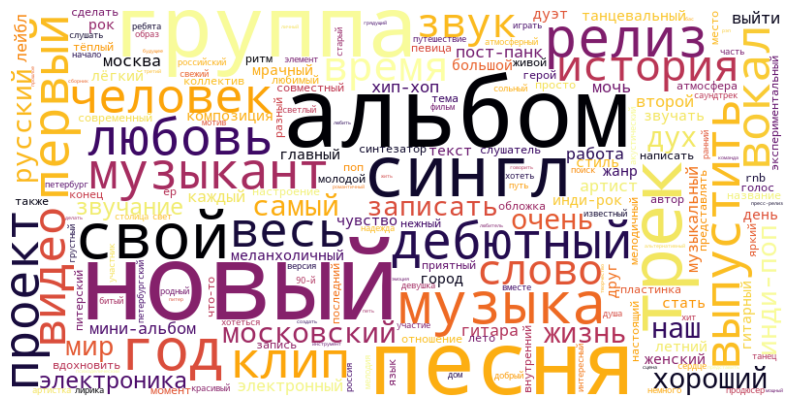

In [33]:
wordcloud_from_freq(lemma_freq_music)

In [34]:
noun_freq_music = lemma_tag_freq(posts_music, 'NOUN')
noun_freq_music.sort_values('freq', ascending=False)[:20]

,lemma,freq,rel_freq
14,альбом,5479,0.029014
10,песня,4467,0.023655
137,группа,4143,0.021939
104,трек,2943,0.015584
20,сингл,2674,0.014160
15,год,1800,0.009532
74,музыка,1796,0.009511
40,релиз,1532,0.008113
21,любовь,1380,0.007308
204,музыкант,1323,0.007006


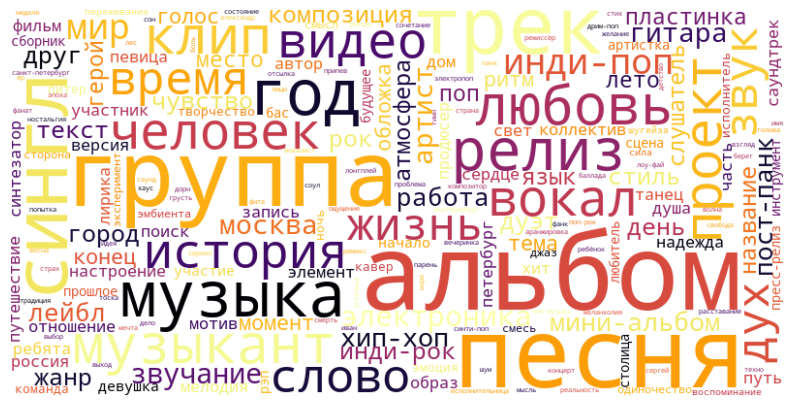

In [35]:
wordcloud_from_freq(noun_freq_music)

In [36]:
adjf_freq_music = lemma_tag_freq(posts_music, 'ADJF')
adjf_freq_music.sort_values('freq', ascending=False)[:20]

,lemma,freq,rel_freq
6,новый,6732,0.077892
5,свой,2231,0.025814
2,первый,1381,0.015979
56,дебютный,1287,0.014891
88,весь,1165,0.013480
296,московский,989,0.011443
128,самый,980,0.011339
26,наш,943,0.010911
204,русский,852,0.009858
15,электронный,781,0.009037


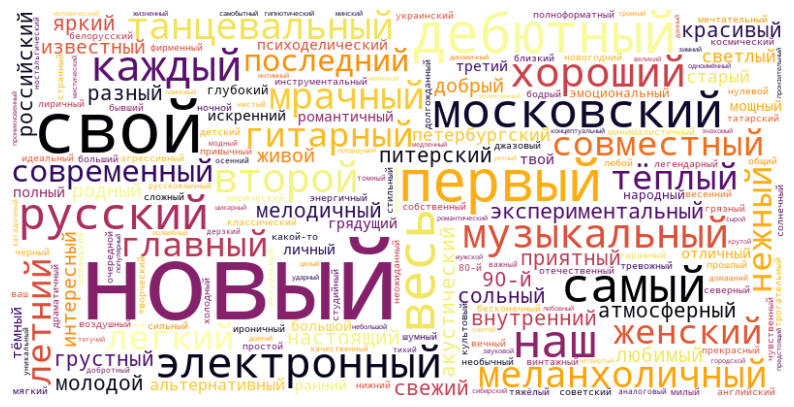

In [37]:
wordcloud_from_freq(adjf_freq_music)

In [38]:
verb_freq_music = lemma_tag_freq(posts_music, 'VERB')
verb_freq_music.sort_values('freq', ascending=False)[:20]

,lemma,freq,rel_freq
18,выпустить,1129,0.039039
55,мочь,669,0.023133
139,выйти,560,0.019364
36,звучать,533,0.018430
34,стать,389,0.013451
1,представлять,324,0.011203
44,хотеться,321,0.011100
43,хотеть,268,0.009267
272,записать,248,0.008575
186,получиться,219,0.007573


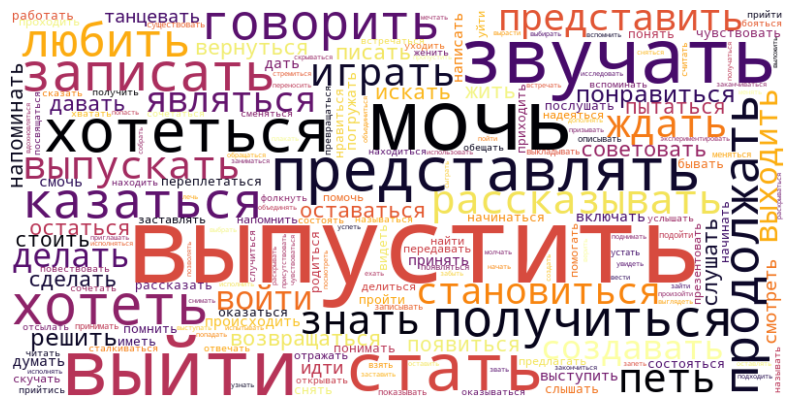

In [39]:
wordcloud_from_freq(verb_freq_music)

Проведем примитивный анализ корпуса на его насыщенность эмотивной лексикой. Для этого воспользуемся словарем эмотивной лексики, который мы ранее спарсили, и посчитаем долю токенов из него, которые встречаются в нашем корпусе.

In [40]:
emot_lex_df = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/emot_lex.csv', sep=',')
emot_lex_list = ' '.join(emot_lex_df['Токены'].tolist()).split()
print(f'Количество токенов в нашем словаре эмотивной лексики: {len(set(emot_lex_list))}')

Количество токенов в нашем словаре эмотивной лексики: 4988


In [41]:
#Функция для вывода эмотивной лексики среди лемм
def emot_lex_search(lemmas):
    emot_lex = [lemma for lemma in lemmas if lemma[0] in emot_lex_list]
    return emot_lex

In [42]:
posts_music['emot_lex_tokens'] = posts_music['lemmas_no_stop'].apply(emot_lex_search)
display(posts_music.head())

,id,group_id,date,text,cut_text,clean_text,tokens,lemmas,lemmas_no_stop,emot_lex_tokens
0,554302,83415396,2026-01-27 00:22:03,Меланхоличный инди-рок с упором на тексты из М...,Меланхоличный инди-рок с упором на тексты из М...,меланхоличный инди-рок с упором на тексты из м...,"[меланхоличный, инди-рок, с, упором, на, текст...","[[меланхоличный, ADJF], [инди-рок, NOUN], [с, ...","[[меланхоличный, ADJF], [инди-рок, NOUN], [упо...",[]
1,554221,83415396,2026-01-26 18:33:39,Андрей Катиков сделал кавер на Братьев Грим.\n...,Андрей Катиков сделал кавер на Братьев Грим.\n...,андрей катиков сделал кавер на братьев грим ан...,"[андрей, катиков, сделал, кавер, на, братьев, ...","[[андрей, NOUN], [катик, NOUN], [сделать, VERB...","[[андрей, NOUN], [катик, NOUN], [сделать, VERB...",[]
2,554061,83415396,2026-01-26 00:29:00,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,Пёрфект ситуэйшн на вечеринке в сингле от [clu...,пёрфект ситуэйшн на вечеринке в сингле от виа ...,"[пёрфект, ситуэйшн, на, вечеринке, в, сингле, ...","[[пёрфект, NOUN], [ситуэйшн, NOUN], [на, PREP]...","[[пёрфект, NOUN], [ситуэйшн, NOUN], [вечеринка...","[[любовь, NOUN]]"
3,554051,83415396,2026-01-25 23:29:00,Лиричный эмо-панк из Японии.\n\n[club234634477...,Лиричный эмо-панк из Японии.,лиричный эмо-панк из японии,"[лиричный, эмо-панк, из, японии]","[[лиричный, ADJF], [эмо-панк, NOUN], [из, PREP...","[[лиричный, ADJF], [эмо-панк, NOUN], [япония, ...",[]
4,554035,83415396,2026-01-25 22:29:00,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл «бессо...,эфемерная представляет свой новый сингл бессон...,"[эфемерная, представляет, свой, новый, сингл, ...","[[эфемерный, ADJF], [представлять, VERB], [сво...","[[эфемерный, ADJF], [представлять, VERB], [сво...","[[нежный, ADJF], [надежда, NOUN]]"


Создадим также словарь эмотивной лексики по классам, чтобы посмотреть на их распределение, выведем самые частотные леммы из словаря и определим их класс.

In [43]:
emot_lex_df['Токены'] = emot_lex_df['Токены'].apply(lambda x: x.split())
emot_lex_dict = dict(zip(emot_lex_df['Класс'], emot_lex_df['Токены']))

In [44]:
#Функция для определения класса эмоции по словарю
def get_emot_class(lemma):
    return [k for k, v in emot_lex_dict.items() if lemma in v]

#Функция для вывода датафрейма с токеном из словаря эмотивной лексики, его абсолютной и относительной частотностью и классом/классами эмоций
def emot_lex_freq_class(dataframe):
    lemmas_list = [lemma[0] for lemma in dataframe['emot_lex_tokens'].explode().dropna().tolist()]
    freq_lemmas = Counter(lemmas_list)
    df = pd.DataFrame(freq_lemmas.items()).rename(columns={0:'lemma', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(lemmas_list))
    df['class'] = df['lemma'].apply(get_emot_class)
    return df

In [45]:
emot_lex_freq_music = emot_lex_freq_class(posts_music)
emot_lex_freq_music.sort_values('rel_freq', ascending=False)[:50]

,lemma,freq,rel_freq,class
0,любовь,1380,0.039760,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
40,хороший,942,0.027141,"[ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ]"
101,мир,861,0.024807,[СПОКОЙСТВИЕ]
26,мрачный,585,0.016855,[ГРУСТЬ]
65,чувство,532,0.015328,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
11,друг,527,0.015184,[ДРУЖБА]
31,вдохновить,453,0.013052,[ВДОХНОВЕНИЕ]
1,нежный,435,0.012533,[ЛЮБОВЬ]
139,герой,417,0.012015,[ОДОБРЕНИЕ]
25,настоящий,377,0.010862,[ИСКРЕННОСТЬ]


Выбранный примитивный способ подсчета эмотивной лексики имеет большой недостаток: он не учитывает контекст. При этом некоторые слова в скачанном словаре требуют особого контекста, чтобы считаться выражением определенной эмоции. Так как внутри выбранного подхода невозможно утверждать точно, что в данном корпусе эти слова относятся к эмотивной лексике, попробуем удалить их из списка и работать далее с сокращенным вручную словарем. В перспективе проект может существенно улучшен с помощью подбора более точного способа измерения доли эмотивной лексики в корпусе.

In [46]:
words_to_delete = 'зуд опьянелый провертеться сгореть шатание шум сотрясаться сотрястись разойтись расходиться мять разжечь разжигать разогреть разогревать раскалить раскалять сверлить щекотать электризовать наэлектризовать занести заносить порох горячий подъем пламень пламя угар загореться загораться расцвести расцветать зажечь опьянить опьянять поднять поднимать приподнять приподымать присушить присушивать забирать забрать обмануть расположение слабость уйти ферт крест познать познавать принять принимать знать набраться набираться напасть томно камень удар убить убивать жечь одолеть сметь съеть съедать есть ударить ударять удушливый подступить подступать реветь убитый сохнуть высохнуть жгучий лезть неловкий зудеть раздавить раздавливать вздыхать поехать туманный темный черный сумеречный постный обуза сухота предосторожность уход уходить стараться рыцарство ходить отец рыцарский рыцарь сковать сковывать сплавить сплавлять спаять спаивать совет свести связываться короткий произвол животное сердце яд язва змея вредный простой прямой младенческий ребенок перекраситься перекрашиваться жар кипеть огонь пламенеть пламя пламень пыл пылать теплеть теплить сразить сражать победить побеждать принаджелать гулять жить жаловать крутить трепать лизать лизаться приложиться прикладываться таскаться огневой растлить растлевать погрешить грешить топорщиться вспышка гроза бушевать точить укол ронять топтать сцена пусто холодно разделить разделять делить удалить удалять стена гимн осел закиснуть закисать дуб идол кукла пень рыбий петь плавать звезда орел сокол мир светлый холод рутина сахар сахарный возбудить вынести доля друг думать заняться захватить красный общественный обязать ответ предмет претензия признать принадлежать располагать расположить роман связать смотреть сохранить уничтожить участие'
words_to_delete = words_to_delete.split()
len(words_to_delete)

215

In [47]:
emot_lex_list = [token for token in emot_lex_list if token not in words_to_delete]
print(f'Количество токенов в обновленном словаре: {len(set(emot_lex_list))}')

Количество токенов в обновленном словаре: 4777


In [48]:
#with open('emot_lex_list.txt', 'w') as file:
    #file.write(' '.join(emot_lex_list))

In [49]:
posts_music['emot_lex_tokens'] = posts_music['lemmas_no_stop'].apply(emot_lex_search)
emot_lex_tokens_music = [lemma[0] for lemma in posts_music['emot_lex_tokens'].explode().dropna().tolist()]
print(f'Количество токенов из словаря эмотивной лексики в корпусе: {len(emot_lex_tokens_music)}.')
print(f'Из них уникальных: {len(set(emot_lex_tokens_music))}.')
print(f'Доля токенов из словаря эмотивной лексики в корпусе составляет: {len(emot_lex_tokens_music) / len(tokens_music)}.')
posts_music['emot_lex_count'] = posts_music['emot_lex_tokens'].apply(len)
posts_music['word_count'] = posts_music['lemmas'].apply(len)
posts_music['emot_lex_rel_count'] = posts_music['emot_lex_count'].div(posts_music['word_count'])
print(f'Среднее количество токенов из словаря эмотивной лексики на длину публикации: {posts_music['emot_lex_rel_count'].mean()}')

Количество токенов из словаря эмотивной лексики в корпусе: 28251.
Из них уникальных: 1575.
Доля токенов из словаря эмотивной лексики в корпусе составляет: 0.05464177539833895.
Среднее количество токенов из словаря эмотивной лексики на длину публикации: 0.05742501040558038


In [79]:
emot_lex_freq_music = emot_lex_freq_class(posts_music)
emot_lex_freq_music.sort_values('rel_freq', ascending=False).head(50)

,lemma,freq,rel_freq,class
0,любовь,1380,0.048848,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
32,хороший,942,0.033344,"[ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ]"
19,мрачный,585,0.020707,[ГРУСТЬ]
53,чувство,532,0.018831,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
24,вдохновить,453,0.016035,[ВДОХНОВЕНИЕ]
1,нежный,435,0.015398,[ЛЮБОВЬ]
119,герой,417,0.014761,[ОДОБРЕНИЕ]
18,настоящий,377,0.013345,[ИСКРЕННОСТЬ]
43,приятный,364,0.012884,"[ЛЮБОВЬ, УДОВОЛЬСТВИЕ]"
27,настроение,345,0.012212,[ЖЕЛАНИЕ]


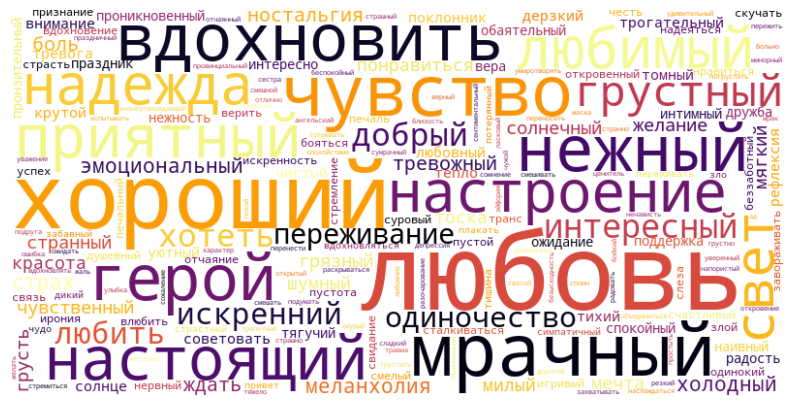

In [51]:
wordcloud_from_freq(emot_lex_freq_music)

Наиболее представленные классы эмотивной лексики в корпусе выглядят следующим образом (некоторые токены из словаря принадлежат более чем одному классу):

In [52]:
emot_lex_freq_music['class_str'] = emot_lex_freq_music['class'].apply(lambda x: ', '.join(x))
emot_lex_freq_music.groupby('class_str')['freq'].sum().sort_values(ascending=False)[:20]

class_str
ГРУСТЬ                        2606
ЛЮБОВЬ                        2560
ВЛЕЧЕНИЕ, ЛЮБОВЬ              2166
РАДОСТЬ                       1807
ГОРЕ                          1550
БЕСПОКОЙСТВО                  1401
ИСКРЕННОСТЬ                   1210
ДОБРОТА                       1091
ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ     942
ЖЕЛАНИЕ                        900
СПОКОЙСТВИЕ                    734
ВДОХНОВЕНИЕ                    734
НАДЕЖДА                        717
ОДОБРЕНИЕ                      658
ОДИНОЧЕСТВО                    638
УДИВЛЕНИЕ                      580
СТРАХ                          580
НЕПРИЯЗНЬ                      554
ДРУЖБА                         548
ЛЮБОПЫТСТВО                    463
Name: freq, dtype: int64

Для контраста рассчитаем те же метрики для референсного корпуса.

In [53]:
lenta['emot_lex_tokens'] = lenta['lemmas_no_stop'].apply(emot_lex_search)
display(lenta.head())
emot_lex_tokens_lenta = [lemma[0] for lemma in lenta['emot_lex_tokens'].explode().dropna().tolist()]
print(f'Количество токенов из словаря эмотивной лексики в корпусе: {len(emot_lex_tokens_lenta)}.')
print(f'Из них уникальных: {len(set(emot_lex_tokens_lenta))}.')
print(f'Доля токенов из словаря эмотивной лексики в корпусе составляет: {len(emot_lex_tokens_lenta) / len(lemmas_no_stop_lenta)}.')
lenta['emot_lex_count'] = lenta['emot_lex_tokens'].apply(len)
lenta['word_count'] = lenta['lemmas'].apply(len)
lenta['emot_lex_rel_count'] = lenta['emot_lex_count'].div(lenta['word_count'])
print(f'Среднее количество токенов из словаря эмотивной лексики на длину публикации: {lenta['emot_lex_rel_count'].mean()}')

,Unnamed: 0,text,clean_text,tokens,lemmas,lemmas_no_stop,emot_lex_tokens
0,21335,\nИранский корабль прошел в опасной близости о...,иранский корабль прошел в опасной близости от ...,"[иранский, корабль, прошел, в, опасной, близос...","[[иранский, ADJF], [корабль, NOUN], [пройти, V...","[[иранский, ADJF], [корабль, NOUN], [пройти, V...","[[опасный, ADJF], [близость, NOUN], [приблизит..."
1,35374,\nБывший тренер пермского «Амкара» Славолюб Му...,бывший тренер пермского амкара славолюб муслин...,"[бывший, тренер, пермского, амкара, славолюб, ...","[[бывший, ADJF], [тренер, NOUN], [пермский, AD...","[[бывший, ADJF], [тренер, NOUN], [пермский, AD...","[[обида, NOUN], [чужой, ADJF]]"
2,14723,\nМинтранс предложил регионам отказаться от об...,минтранс предложил регионам отказаться от обяз...,"[минтранс, предложил, регионам, отказаться, от...","[[минтранс, NOUN], [предложить, VERB], [регион...","[[минтранс, NOUN], [предложить, VERB], [регион...","[[интерес, NOUN]]"
3,29691,"\nГендиректор издательского дома ""Ньюс Медиа Р...",гендиректор издательского дома ньюс медиа рус ...,"[гендиректор, издательского, дома, ньюс, медиа...","[[гендиректор, NOUN], [издательский, ADJF], [д...","[[гендиректор, NOUN], [издательский, ADJF], [д...","[[забота, NOUN], [отметить, VERB], [хотеть, VE..."
4,233,\nВ мужской части Открытого чемпионата Франции...,в мужской части открытого чемпионата франции р...,"[в, мужской, части, открытого, чемпионата, фра...","[[в, PREP], [мужской, ADJF], [часть, NOUN], [о...","[[мужской, ADJF], [часть, NOUN], [открытый, AD...","[[открытый, ADJF], [соперница, NOUN]]"


Количество токенов из словаря эмотивной лексики в корпусе: 9818.
Из них уникальных: 1010.
Доля токенов из словаря эмотивной лексики в корпусе составляет: 0.025685634828653426.
Среднее количество токенов из словаря эмотивной лексики на длину публикации: 0.018908903886694264


In [ ]:
emot_lex_freq_lenta = emot_lex_freq_class(lenta)
emot_lex_freq_lenta.sort_values('rel_freq', ascending=False).head(20)

,lemma,freq,rel_freq,class
11,отметить,530,0.053982,[ОДОБРЕНИЕ]
51,связь,366,0.037278,"[ДРУЖБА, ЛЮБОВЬ]"
50,настоящий,307,0.031269,[ИСКРЕННОСТЬ]
23,хороший,231,0.023528,"[ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ]"
63,подозревать,154,0.015685,[НЕВЕРИЕ]
12,хотеть,148,0.015074,[ЖЕЛАНИЕ]
14,поддержка,146,0.014871,[РАДОСТЬ]
66,обвинить,134,0.013648,[НЕПРИЯЗНЬ]
100,протест,125,0.012732,[ПРОТЕСТ]
37,жертва,120,0.012222,[ГОРЕ]


In [55]:
emot_lex_freq_lenta['class_str'] = emot_lex_freq_lenta['class'].apply(lambda x: ', '.join(x))
emot_lex_freq_lenta.groupby('class_str')['freq'].sum().sort_values(ascending=False)[:20]

class_str
НЕПРИЯЗНЬ                     828
ОДОБРЕНИЕ                     814
ГОРЕ                          730
РАДОСТЬ                       534
ИСКРЕННОСТЬ                   514
ЛЮБОВЬ                        466
ДРУЖБА, ЛЮБОВЬ                380
СТРАХ                         363
НЕДОВОЛЬСТВО                  347
ДОБРОТА                       332
ЖЕЛАНИЕ                       316
НЕВЕРИЕ                       316
ОДИНОЧЕСТВО                   279
НАДЕЖДА                       253
ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ    231
ДРУЖБА                        213
ВЛЕЧЕНИЕ                      197
ВЕРА                          189
ЛЮБОПЫТСТВО                   178
ПРОТЕСТ                       177
Name: freq, dtype: int64

Для работы над коллокациями создадим из лемм внутри датафрейма список из списков (документов).

In [56]:
lemmas_list_music = posts_music['lemmas_no_stop'].apply(lambda x: [lemma[0] for lemma in x]).tolist()

In [57]:
#Функция для вывода биграмм, которая принимает список документов, метрику и ее название (для датафрейма)
def bigrams_by_measure(documents, measure, measure_name):
    bigram_finder = BigramCollocationFinder.from_documents(documents)
    min_freq = 2
    bigram_finder.apply_freq_filter(min_freq)
    scores = bigram_finder.score_ngrams(measure)

    bigram_df = pd.DataFrame([[' '.join(bigram), bigram[0], bigram[1], bigram_finder.ngram_fd[bigram], score] for bigram, score in scores], columns=['bigram', 'word_1', 'word_2', 'freq', measure_name])
    bigram_df.sort_values(by=measure_name, ascending=False, inplace=True, ignore_index=True)
    return bigram_df

In [58]:
#Функция для вывода триграмм, которая принимает список документов, метрику и ее название (для датафрейма)
def trigrams_by_measure(documents, measure, measure_name):
    trigram_finder = TrigramCollocationFinder.from_documents(documents)
    min_freq = 2
    trigram_finder.apply_freq_filter(min_freq)
    scores = trigram_finder.score_ngrams(measure)

    trigram_df = pd.DataFrame([[' '.join(trigram), trigram[0], trigram[1], trigram[2], trigram_finder.ngram_fd[trigram], score] for trigram, score in scores], columns=['trigram', 'word_1', 'word_2', 'word_3', 'freq', measure_name])
    trigram_df.sort_values(by=measure_name, ascending=False, inplace=True, ignore_index=True)
    return trigram_df

In [59]:
trigrams_student_t = trigrams_by_measure(lemmas_list_music, nltk.collocations.TrigramAssocMeasures().student_t, 'student_t')
display(trigrams_student_t.head(20))

,trigram,word_1,word_2,word_3,freq,student_t
0,выпустить новый альбом,выпустить,новый,альбом,99,9.914164
1,сингл грядущий альбом,сингл,грядущий,альбом,69,8.303476
2,новый альбом группа,новый,альбом,группа,65,7.923089
3,выпустить новый сингл,выпустить,новый,сингл,62,7.851985
4,новый сингл группа,новый,сингл,группа,59,7.609855
5,сингл новый альбом,сингл,новый,альбом,48,6.823678
6,новый релиз лейбл,новый,релиз,лейбл,42,6.473029
7,дебютный альбом московский,дебютный,альбом,московский,42,6.472870
8,выпустить новый трек,выпустить,новый,трек,41,6.373318
9,первый сингл новый,первый,сингл,новый,37,6.052755


In [102]:
trigrams_likelihood = trigrams_by_measure(lemmas_list_music, nltk.collocations.TrigramAssocMeasures().likelihood_ratio, 'likelihood_ratio')
display(trigrams_likelihood.head(20))

,trigram,word_1,word_2,word_3,freq,likelihood_ratio
0,выпустить новый сингл,выпустить,новый,сингл,62,6429.080176
1,новый сингл грядущий,новый,сингл,грядущий,11,5652.303333
2,выпустить новый альбом,выпустить,новый,альбом,99,5471.827925
3,новый сингл московский,новый,сингл,московский,36,5262.470961
4,новый сингл предстоящий,новый,сингл,предстоящий,5,5179.048197
5,новый сингл группа,новый,сингл,группа,59,5147.426532
6,представлять новый сингл,представлять,новый,сингл,19,5091.503154
7,возвращаться новый сингл,возвращаться,новый,сингл,13,5070.522975
8,представить новый сингл,представить,новый,сингл,15,5017.163749
9,новый сингл питерский,новый,сингл,питерский,12,5012.316366


In [61]:
bigrams_student_t = bigrams_by_measure(lemmas_list_music, nltk.collocations.BigramAssocMeasures().student_t, 'student_t')
display(bigrams_student_t.head(30))

,bigram,word_1,word_2,freq,student_t
0,новый альбом,новый,альбом,1136,30.733538
1,новый сингл,новый,сингл,1021,30.423596
2,дебютный альбом,дебютный,альбом,532,22.238316
3,выпустить новый,выпустить,новый,369,17.961070
4,женский вокал,женский,вокал,321,17.834996
5,новый видео,новый,видео,330,17.061201
6,новый клип,новый,клип,308,16.229414
7,новый трек,новый,трек,359,16.108445
8,новый песня,новый,песня,406,16.097601
9,новый релиз,новый,релиз,273,14.828074


In [62]:
bigrams_likelihood = bigrams_by_measure(lemmas_list_music, nltk.collocations.BigramAssocMeasures().likelihood_ratio, 'likelihood_ratio')
display(bigrams_likelihood.head(30))

,bigram,word_1,word_2,freq,likelihood_ratio
0,новый сингл,новый,сингл,1021,4827.986325
1,новый альбом,новый,альбом,1136,3833.244456
2,женский вокал,женский,вокал,321,3219.260237
3,дебютный альбом,дебютный,альбом,532,2809.204220
4,cream soda,cream,soda,100,1738.551587
5,выпустить новый,выпустить,новый,369,1447.675737
6,иван дорн,иван,дорн,97,1350.903074
7,новый видео,новый,видео,330,1342.007147
8,синекдоха монток,синекдоха,монток,70,1298.449222
9,слово музыкант,слово,музыкант,202,1290.965903


In [63]:
bigrams_likelihood[bigrams_likelihood['word_2'] == 'сингл'].head(30)

,bigram,word_1,word_2,freq,likelihood_ratio
0,новый сингл,новый,сингл,1021,4827.986325
21,первый сингл,первый,сингл,222,1005.073152
49,дебютный сингл,дебютный,сингл,164,660.429426
70,второй сингл,второй,сингл,115,528.830201
305,двойной сингл,двойной,сингл,29,203.545555
612,третий сингл,третий,сингл,33,135.954959
631,совместный сингл,совместный,сингл,40,133.469569
848,свежий сингл,свежий,сингл,32,111.154693
2000,выпустить сингл,выпустить,сингл,42,61.157225
2241,летний сингл,летний,сингл,25,56.272276


In [64]:
bigrams_likelihood[(bigrams_likelihood['word_2'] == 'песня') & (bigrams_likelihood['word_1'].apply(lambda x: morph.parse(x)[0].tag.POS) == 'ADJF')].head(30)

,bigram,word_1,word_2,freq,likelihood_ratio
43,новый песня,новый,песня,406,694.655197
373,народный песня,народный,песня,45,181.390279
678,каждый песня,каждый,песня,60,127.310395
744,заглавный песня,заглавный,песня,23,121.534923
2001,старый песня,старый,песня,25,61.142430
2432,совместный песня,совместный,песня,29,53.044188
2979,свадебный песня,свадебный,песня,7,47.513209
3128,любимый песня,любимый,песня,24,45.995040
3310,новогодний песня,новогодний,песня,16,44.869844
3859,грустный песня,грустный,песня,21,40.755980


Попробуем узнать, какие прилагательные встречаются рядом друг с другом чаще других в окне размером в 5. Так как в BigramCollocationFinder.from_documents нельзя задать окно, воспользуемся другой функцией.

In [96]:
#Функция для рассчета likelihood ratio для прилагательных в заданном окне по списку документов (тут помогал chat-gpt)
def adj_bigrams_likelihood_ratio(documents, morph, window_size, min_freq):
    #словари для частотностей
    bigram_counts = {}
    unigram_counts = {}
    total_windows = 0
    #для сглаживания
    epsilon = 1e-10

    #считаем частотность прилагательных и их пар
    for doc in documents:
        for i in range(len(doc)):

            start = max(0, i - window_size // 2)
            end = min(len(doc), i + window_size // 2 + 1)
            window = doc[start:end]
            total_windows += 1

            adjs = []

            for word in window:
                parsed = morph.parse(word)[0]
                if parsed.tag.POS == 'ADJF':
                    adjs.append(word)
                    if word in unigram_counts:
                        unigram_counts[word] += 1
                    else:
                        unigram_counts[word] = 1

            #пары прилагательных
            for w1, w2 in combinations(adjs, 2):
                if w1 == w2:
                    continue
                pair = tuple(sorted([w1, w2]))
                if pair in bigram_counts:
                    bigram_counts[pair] += 1
                else:
                    bigram_counts[pair] = 1

    #фильтруем по частоте
    filtered_bigrams = {}
    for pair, count in bigram_counts.items():
        if count >= min_freq:
            filtered_bigrams[pair] = count
    
    #подсчитываем likelihood ratio
    results = []
    N = total_windows

    for (w1, w2), o11 in filtered_bigrams.items():

        w1_count = unigram_counts[w1]
        w2_count = unigram_counts[w2]
        o12 = w1_count - o11
        o21 = w2_count - o11
        o22 = N - (o11 + o12 + o21)

        exp_11 = (w1_count * w2_count) / N
        exp_12 = (w1_count * (N - w2_count)) / N
        exp_21 = ((N - w1_count) * w2_count) / N
        exp_22 = ((N - w1_count) * (N - w2_count)) / N

        llr = 0

        if o11 > 0:
            llr += o11 * log((o11 + epsilon) / (exp_11 + epsilon))
        if o12 > 0:
            llr += o12 * log((o12 + epsilon) / (exp_12 + epsilon))
        if o21 > 0:
            llr += o21 * log((o21 + epsilon) / (exp_21 + epsilon))
        if o22 > 0:
            llr += o22 * log((o22 + epsilon) / (exp_22 + epsilon))

        llr *= 2

        results.append([w1 + " " + w2, w1, w2, o11, llr])

    df = pd.DataFrame(results, columns=['bigram', 'word_1', 'word_2', 'freq', 'likelihood_ratio'])

    df.sort_values(by='likelihood_ratio', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [97]:
adj_likelihood = adj_bigrams_likelihood_ratio(lemmas_list_music, morph, 5, 2)
display(adj_likelihood.head(25))

,bigram,word_1,word_2,freq,likelihood_ratio
0,любимый наш,любимый,наш,468,2266.119970
1,встречный старенький,встречный,старенький,56,841.770091
2,женский мужской,женский,мужской,107,608.392637
3,народный русский,народный,русский,147,516.014903
4,грядущий первый,грядущий,первый,174,473.379647
5,дебютный московский,дебютный,московский,284,437.796165
6,первый полноформатный,первый,полноформатный,148,416.068602
7,второй грядущий,второй,грядущий,112,371.507928
8,гаражный грязный,гаражный,грязный,63,367.415120
9,второй полноформатный,второй,полноформатный,103,366.898524


In [100]:
filter_adjs = ['новый', 'первый', 'второй', 'весь', 'битый', 'самый', 'третий']
adj_likelihood[~(adj_likelihood['word_1'].isin(filter_adjs) | adj_likelihood['word_2'].isin(filter_adjs))].head(25)

,bigram,word_1,word_2,freq,likelihood_ratio
0,любимый наш,любимый,наш,468,2266.119970
1,встречный старенький,встречный,старенький,56,841.770091
2,женский мужской,женский,мужской,107,608.392637
3,народный русский,народный,русский,147,516.014903
5,дебютный московский,дебютный,московский,284,437.796165
8,гаражный грязный,гаражный,грязный,63,367.415120
10,жуковский подмосковный,жуковский,подмосковный,31,366.683625
12,ангельский женский,ангельский,женский,48,329.353553
13,внешний внутренний,внешний,внутренний,53,326.641830
15,главный отечественный,главный,отечественный,73,300.144993


Среди наиболее частотных существительных мое внимание привлекли леммы "дух" и "история". Удалим некоторые токены из списка стоп-слов, чтобы посмотреть на возможные коллокации с ними.

In [68]:
to_delete = ['о', 'про', 'в', 'тот']
new_stopwords_ru = [word for word in stopwords_ru if word not in to_delete]
lemmas_list_sw_music = posts_music['lemmas'].apply(lambda x: [lemma[0] for lemma in x if lemma[0] not in new_stopwords_ru]).tolist()

In [69]:
bigrams_likelihood_new = bigrams_by_measure(lemmas_list_sw_music, nltk.BigramAssocMeasures().likelihood_ratio, 'likelihood_ratio')
display(bigrams_likelihood_new.head(20))

,bigram,word_1,word_2,freq,likelihood_ratio
0,новый сингл,новый,сингл,1020,4939.430661
1,в дух,в,дух,775,4257.439323
2,новый альбом,новый,альбом,1136,3961.032306
3,о тот,о,тот,627,3514.051143
4,женский вокал,женский,вокал,321,3257.520946
5,дебютный альбом,дебютный,альбом,532,2871.505992
6,cream soda,cream,soda,100,1750.479471
7,песня о,песня,о,540,1658.294830
8,выпустить новый,выпустить,новый,369,1489.777955
9,новый видео,новый,видео,330,1379.802794


In [70]:
trigrams_likelihood = trigrams_by_measure(lemmas_list_sw_music, nltk.collocations.TrigramAssocMeasures().likelihood_ratio, 'likelihood_ratio')
display(trigrams_likelihood.head(20))

,trigram,word_1,word_2,word_3,freq,likelihood_ratio
0,выпустить новый сингл,выпустить,новый,сингл,62,6588.067823
1,новый сингл грядущий,новый,сингл,грядущий,11,5777.870750
2,выпустить новый альбом,выпустить,новый,альбом,99,5649.728862
3,новый сингл московский,новый,сингл,московский,36,5392.152578
4,новый сингл предстоящий,новый,сингл,предстоящий,5,5296.066837
5,новый сингл группа,новый,сингл,группа,59,5282.330553
6,в новый сингл,в,новый,сингл,68,5270.748943
7,представлять новый сингл,представлять,новый,сингл,19,5212.035303
8,возвращаться новый сингл,возвращаться,новый,сингл,13,5181.316571
9,песня о тот,песня,о,тот,67,5173.913965


In [71]:
trigrams_likelihood[trigrams_likelihood['word_2'] == 'дух'].head(30)

,trigram,word_1,word_2,word_3,freq,likelihood_ratio
167,в дух ранний,в,дух,ранний,64,4757.508766
172,в дух время,в,дух,время,3,4444.197027
174,в дух 90-й,в,дух,90-й,18,4392.297740
175,в дух группа,в,дух,группа,37,4367.499449
181,в дух 80-й,в,дух,80-й,10,4345.936037
184,в дух fka,в,дух,fka,8,4324.542297
185,в дух james,в,дух,james,8,4323.617298
186,в дух xx,в,дух,xx,9,4322.907439
187,в дух neighbourhood,в,дух,neighbourhood,7,4319.084917
188,в дух 70-й,в,дух,70-й,7,4317.319694


In [72]:
trigrams_likelihood[(trigrams_likelihood['word_1'] == 'песня') & (trigrams_likelihood['word_2'] == 'о')].head(30)

,trigram,word_1,word_2,word_3,freq,likelihood_ratio
9,песня о тот,песня,о,тот,67,5173.913965
908,песня о любовь,песня,о,любовь,51,2721.218857
916,песня о поиск,песня,о,поиск,8,1951.178116
921,песня о вечный,песня,о,вечный,2,1846.557302
923,песня о внутренний,песня,о,внутренний,8,1825.816213
924,песня о расставание,песня,о,расставание,10,1824.457941
926,песня о взросление,песня,о,взросление,3,1808.229901
928,песня о чувство,песня,о,чувство,10,1791.171095
933,песня о одиночество,песня,о,одиночество,3,1771.382525
937,песня о принятие,песня,о,принятие,4,1763.461071


In [73]:
trigrams_likelihood[(trigrams_likelihood['word_1'] == 'история') & (trigrams_likelihood['word_2'] == 'о')].head(30)

,trigram,word_1,word_2,word_3,freq,likelihood_ratio
166,история о тот,история,о,тот,42,4872.104186
912,история о любовь,история,о,любовь,17,2453.636795
1085,история о поиск,история,о,поиск,6,1651.583807
1107,история о внутренний,история,о,внутренний,3,1520.271403
1113,история о расставание,история,о,расставание,2,1518.121091
1119,история о взросление,история,о,взросление,5,1514.203662
1162,история о отношение,история,о,отношение,3,1497.809567
1168,история о чувство,история,о,чувство,4,1487.902317
1171,история о прощание,история,о,прощание,3,1468.473856
1172,история о одиночество,история,о,одиночество,3,1468.071285
